# Project work - Air pollution and covid-19

## Which effect did the restrictions have on no2 levels across scandinavia and to what extend could they help live up to guidelines from WHO.

### Introduction
Link: https://www.greenfacts.org/en/nitrogen-dioxide-no2/

Link: https://dce.au.dk/aktuelt/nyheder/nyhed/artikel/nyt-beregningsgrundlag-viser-hoejere-pris-for-luftforurening/ 

Cities around the world are all affected by air pollution from vehicles and other pollutants. Most of these are closely linked to the same pollutants and it can therefore be hard to seperate their effect. It is known though that air pollution is a large problem, even in countries that define themself as green and developed countries. Studies from Denmark showed that air pollitions cause more than 4000 persons to die too early and a societal cost of more than 75 billions yearly. These are quite large numbers for a small country as Denmark and suggest that considerable savings can be made by decreasing air pollution.


Link: https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines

As much of the air pollution comes from transportation in cities, it is assumed that the corona lockdowns would decrease the air pollution considerably. Therefore the effect on air pollution of the different lockdown measures will be compared with pre-covid levels for multiple large citites across Scandinavia. As a measure of the effect of the lockdowns the air pollutant NO2, which is assosiated with decreased lung capacity and in some studies, increased mortality, will be accessed. These NO2 levels will then be compared to the guidelines for pollution set by WHO. These guidelines are 10 $\mu g / m^3$ on an yearly average and $25 \mu g/m^3$ on a daily average.


### The website - How to read
The website should be read as a story from top to bottom at the home page. If you are further interested in additional plots for summary statistics, or more information about the how and where the data is collected, this can be found in the tabs called respectively "Visualizations" and "Data". The source code, i.e. the explainer notebook can be found in the tab "Notebook" (it is this file), and all references made on the website can be found under "References".

### Data collection.

To analyse the effect of corona lockdowns on air pollution in cities across Scandinavia two main data sources are used.


#### NO2 Data
The first source is data on NO2 levels collected from the European Environment Information and Observation Network, which is a partnership network of the European Enviornmental Agency (EEA). Each dataset consist of hourly observation across a year from a measurement station. This is then collected for 2019 and 2020, for 2 cities across Finland, Denmark, Norway and Sweden. 

Link: https://www.eionet.europa.eu/

Link: https://discomap.eea.europa.eu/map/fme/AirQualityExport.htm

#### Restrictions measures.
The second source is the European Centre for Disease Prevention and Control, where a dataset of the restrictions enforced by each country and the period in effect is collected. This is used to see which social restrictions was enforced at any given time and then compare to the NO2 levels. 

Link: https://www.ecdc.europa.eu/en/publications-data/download-data-response-measures-covid-19

### NO2 data
The chosen data for this project consists of 16 data sets. These are data sets of $NO_2$ concentration in Copenhagen and Århus in Denmark, Helsinki and Oulu in Finland, Oslo and Trondheim in Norway, and Stockholm and Umeå in Sweden in respectively 2019 and 2020 for each location.

The NO2 data used in this notebook is data collected from the European Environment Information and Observation Network.
Each of the datasets consist of multiple columns as seen on the official website (indsæt reference), and each of these sets has a size of 2160-2220 KB.

The columns of interest from the original data sets in this notebook are 
 - *Concentration*: The measured value of the concentration of $NO_2$ in $\mu g/ m^3$ for each data point
 - *SamplingPoint*: Localid of the samplingpoint
 - *DatetimeBegin*: The start time (yyyy-mm-dd hh:mm:ss Z) of the measurement (including timezone)
 - *DatetimeEnd*: The end time (yyyy-mm-dd hh:mm:ss Z) of the measurement (including timezone)
 - *Validity*: The validity flag for the measurement. (http://dd.eionet.europa.eu/vocabulary/aq/observationvalidity/view)
 - *Verification*: The verification flag for the measurement. (http://dd.eionet.europa.eu/vocabulary/aq/observationverification/view)
 
Each set initially consists of the 6 columns mentioned above, and a number of rows corresponding to number of observations, depending on the year and location.
The number of observations per location per year can be seen in the table below. For most locations this is consistent with 1 observation per hour (= 8760 observations in 2019 and 8784 observations in 2020).

|Location/Year| 2019 | 2020 |
|:------------|:-----|:-----|
| København   | 8760 | 8784 | 
| Århus       | 8760 | 8784 |
| Helsinki    | 8760 | 8783 |
| Oulu        | 8760 | 8783 |
| Oslo        | 8760 | 8784 |
| Trondheim   | 8760 | 8784 |
| Stockholm   | 8699 | 8697 |
| Umeå        | 8609 | 8392 |
 
As we need the locations of the measuring stations, we use the metadata (collected also by the European Environment Information and Observation Network, and is found at https://discomap.eea.europa.eu/map/fme/AirQualityExport.htm). From this we use 
 - *Countrycode*: Country iso code
 - *SamplingPoint*: Localid of samplingpoint
 - *AirQualityStationType*: Short name of station type
 - *AirQualityStationArea*: Reference to area code
 - *Longitude*: Longitude of samplingpoint
 - *Latitude*: Latitude of samplingpoint
 
The original metadata has a file size of 23,942 GB, containing all metadata from all measuring station all over Europe, and so, the size of the data that we are working with in the notebook is significantly smaller.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource, Legend, HoverTool
from bokeh.plotting import figure, output_file, show
from bokeh.layouts import layout
from bokeh.models.widgets import Tabs, Panel
from bokeh.io import curdoc, output_notebook
import seaborn as sns
import geopandas as gpd
import folium
from folium.plugins import TimeSliderChoropleth
import json
import branca.colormap as cm
import datetime
from folium import plugins
from folium.plugins import HeatMap

# LOAD DATA FOR NO2

In [2]:
### Import data sets v2
dk_label = ["2019 - København", "2020 - København", "2019 - Århus", "2020 - Århus"]
fi_label = ["2019 - Helsinki", "2020 - Helsinki", "2019 - Oulu", "2020 - Oulu"]
no_label = ["2019 - Oslo", "2020 - Oslo", "2019 - Trondheim", "2020 - Trondheim"]
se_label = ["2019 - Stockholm", "2020 - Stockholm", "2019 - Umeå", "2020 - Umeå"]
labels = dk_label[:] + fi_label[:] + no_label[:] + se_label[:]
## Import data sets from Denmark
columns = ["Concentration", "SamplingPoint","DatetimeBegin", "DatetimeEnd","Validity","Verification"]

# København
dk2019 = pd.read_csv("data2/DK_8_9294_2019_timeseries.csv", sep=',',usecols=columns) 
dk2020 = pd.read_csv("data2/DK_8_9294_2020_timeseries.csv", sep=',',usecols=columns)
# Århus
dk2019_2 = pd.read_csv("data2/DK_8_9179_2019_timeseries.csv", sep=',',usecols=columns)
dk2020_2 = pd.read_csv("data2/DK_8_9179_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Finland
# Helsinki
fi2019 = pd.read_csv("data2/FI_8_15510_2019_timeseries.csv", sep=',',usecols=columns)
fi2020 = pd.read_csv("data2/FI_8_15510_2020_timeseries.csv", sep=',',usecols=columns)
# Oulu
fi2019_2 = pd.read_csv("data2/FI_8_15639_2019_timeseries.csv", sep=',',usecols=columns)
fi2020_2 = pd.read_csv("data2/FI_8_15639_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Norway
# Oslo
no2019 = pd.read_csv("data2/NO_8_28784_2019_timeseries.csv", sep=',',usecols=columns)
no2020 = pd.read_csv("data2/NO_8_28784_2020_timeseries.csv", sep=',',usecols=columns)

# Trondheim
no2019_2 = pd.read_csv("data2/NO_8_48878_2019_timeseries.csv", sep=',',usecols=columns)
no2020_2 = pd.read_csv("data2/NO_8_48878_2020_timeseries.csv", sep=',',usecols=columns)

## Import data sets from Sweden
# Stockholm
se2019 = pd.read_csv("data2/SE_8_30921_2019_timeseries.csv", sep=',',usecols=columns)
se2020 = pd.read_csv("data2/SE_8_30921_2020_timeseries.csv", sep=',',usecols=columns)
# Umeå
se2019_2 = pd.read_csv("data2/SE_8_30905_2019_timeseries.csv", sep=',',usecols=columns)
se2020_2 = pd.read_csv("data2/SE_8_30905_2020_timeseries.csv", sep=',',usecols=columns)

# Load metadata from datasets
metadata_columns = ["Countrycode", "SamplingPoint", "AirQualityStationType", "AirQualityStationArea", 'Longitude', 'Latitude']
metadata = pd.read_csv("data2/PanEuropean_metadata.csv", sep='\t', usecols=metadata_columns)

# Initial work on data
data = [dk2019, dk2020, dk2019_2, dk2020_2, fi2019, fi2020, fi2019_2, fi2020_2, no2019, no2020, no2019_2, no2020_2, se2019, se2020, se2019_2, se2020_2]
met = {} # dict for metadata

# dicts for daily, weekly and monthly means
daily_means = {}
weekly_means = {}
monthly_means = {}

for i in range(len(data)): # For each data set
    ## Add relevant columns
    data[i]["DatetimeBegin"] = pd.to_datetime(data[i]["DatetimeBegin"], format="%Y-%m-%d %H:%M") # Convert date to datetime
    data[i]["Date"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).date # Store date in seperate column
    data[i]["Week"] = pd.array(pd.DatetimeIndex(data[i]["DatetimeBegin"]).isocalendar().week) # Store week in seperate column
    data[i]["Month"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).month # Store month in seperate column
    data[i]["Year"] = pd.DatetimeIndex(data[i]["DatetimeBegin"]).year # Store month in seperate column
    data[i]=data[i].drop(columns=["DatetimeBegin", "DatetimeEnd"])
    ## Determine longitude and latitude to for each measuring station
    met[i] = metadata[metadata["SamplingPoint"] == data[i]["SamplingPoint"].unique()[0]]
    
    ## Add longitude and latitude for each measuring station
    data[i]["lon"] = met[i]["Longitude"].iloc[0]
    data[i]["lat"] = met[i]["Latitude"].iloc[0]
    
    print("Number of NaNs in dataset ", labels[i], " = ", np.sum(data[i]['Concentration'].isna()))
    
    ## Find monthly means
    monthly_means[i] = data[i][["Concentration", "Month"]].groupby(["Month"]).mean().reset_index()
    if sum(data[i]['Concentration'].isna())!=0:
        for j in range(1,13):
            data[i].loc[(data[i]['Concentration'].isna()) & (data[i]['Month']==j),'Concentration']=monthly_means[i][monthly_means[i]['Month']==j].Concentration[j-1]
            
    # Find daily and weekly means
    daily_means[i] = data[i][["Concentration", "Date"]].groupby(["Date"]).mean().reset_index()
    weekly_means[i] = data[i][["Concentration", "Week"]].groupby(["Week"]).mean().reset_index()

Number of NaNs in dataset  2019 - København  =  682
Number of NaNs in dataset  2020 - København  =  613
Number of NaNs in dataset  2019 - Århus  =  467
Number of NaNs in dataset  2020 - Århus  =  445
Number of NaNs in dataset  2019 - Helsinki  =  135
Number of NaNs in dataset  2020 - Helsinki  =  28
Number of NaNs in dataset  2019 - Oulu  =  1485
Number of NaNs in dataset  2020 - Oulu  =  37
Number of NaNs in dataset  2019 - Oslo  =  392
Number of NaNs in dataset  2020 - Oslo  =  1206
Number of NaNs in dataset  2019 - Trondheim  =  623
Number of NaNs in dataset  2020 - Trondheim  =  588
Number of NaNs in dataset  2019 - Stockholm  =  0
Number of NaNs in dataset  2020 - Stockholm  =  0
Number of NaNs in dataset  2019 - Umeå  =  0
Number of NaNs in dataset  2020 - Umeå  =  0


In the above we find that most of the datasets has NaN-values. This is handled by assigning the value of the monthly mean for the proper month to the times for which the concentration is NaN. We have chosen to use the monthly mean, as we observe that the weekly and daily means also are NaN at some times.

# LOAD DATA FOR RESTRICTIONS AND INITIAL DATA DESCRIPTION

In [3]:
#Reading the data file for corona shutdowns
# https://www.ecdc.europa.eu/en/publications-data/download-data-response-measures-covid-19
df=pd.read_csv("data2/response_graphs_data_2022-04-21.csv")
df.describe()

Country         Response_measure  date_start    date_end
count          2051                     2051        2051        1899
unique           30                       66         414         436
top     Netherlands  RestaurantsCafesPartial  2020-03-16  2020-06-30
freq            114                       75         120          32

The data seems to be fairly consistent. First of all a total of 2051 rows exists and all rows have a country register, which response measure and a start time of the response measure. 252 rows do not have an end date, which is corresponding to the restriction still being in effect. Now to process the data, we limit it to only consists of the countries of interest and only access restrictions in effect in 2020, where we have air pollution data. 

In [4]:
countries=["Denmark","Finland","Norway","Sweden"]#List of countries of interest
df=df[df["Country"].isin(countries)]#Keep only countries
df["date_end"]=df['date_end'].fillna('2020-12-31')#Fill na values with last date
df["date_start"]=pd.to_datetime(df["date_start"])# Change to datetime
df["date_end"]=pd.to_datetime(df["date_end"])#Change to datetime
df=df[df["date_start"]<"2021-01-01"]#Keep only date for 2020

Then a column is created for containing a list of dates that a each restriction was in effect.

In [5]:
df['DATE_VALUE'] = df.apply(lambda x: pd.date_range(start=x['date_start'], end=x['date_end']), axis=1)#Create column to contain date ranges for each restriction

Finally this list is exploded to create a row for each day a restrictions was in effect instead of each row corresponding to a time interval. Observations on restrictions after 2020 is also dropped again with the reference to the end data of air pollution data. 

In [6]:
df = df.explode('DATE_VALUE').reset_index(drop=True)# Explode data so one row is created for each day in the date range
df=df[df["DATE_VALUE"]<"2021-01-01"] # Only keep data from 2020
df=df[['Country','Response_measure','DATE_VALUE']] # Only keep relevant columns.

Now the different restrictions are assesed.

In [7]:
print("Number of different restriction types in data: ", len(df.Response_measure.unique()),"\n")
print("List of different restriction types: ")
df.Response_measure.unique()

Number of different restriction types in data:  41 

List of different restriction types: 


array(['AdaptationOfWorkplace', 'AdaptationOfWorkplacePartial',
       'BanOnAllEvents', 'ClosDaycare', 'ClosHigh', 'ClosPrim',
       'ClosPubAny', 'ClosPubAnyPartial', 'ClosSec',
       'EntertainmentVenues', 'GymsSportsCentres', 'IndoorOver50',
       'IndoorOver500', 'MasksMandatoryClosedSpaces',
       'MasksVoluntaryAllSpacesPartial',
       'MasksVoluntaryClosedSpacesPartial', 'MassGather50',
       'MassGatherAll', 'MassGatherAllPartial', 'NonEssentialShops',
       'NonEssentialShopsPartial', 'OutdoorOver100', 'OutdoorOver50',
       'OutdoorOver500', 'PlaceOfWorship', 'PrivateGatheringRestrictions',
       'QuarantineForInternationalTravellers', 'RestaurantsCafes',
       'RestaurantsCafesPartial', 'StayHomeRiskG', 'Teleworking',
       'TeleworkingPartial', 'WorkplaceClosures', 'ClosHighPartial',
       'ClosSecPartial', 'EntertainmentVenuesPartial',
       'MasksVoluntaryClosedSpaces', 'MassGather50Partial',
       'QuarantineForInternationalTravellersPartial',
       'Stay

As seen a total of 41 different type of restrictions was used across the four countries. It should be noted though, that some are closely linked or more extreme measure of others (such as MassGatherAll, MassGatherAllPartial and MassGather50). It should therefore be expected that the effect is quite different for the different restrictions, but also that they are much differently represented in the dataset. 

Now some inital visualization is performed to get some more infomration on the data. First a countplot of the different response measures is assessed. It is clear to see that some restrictions are popular and was in effect for most of 2020, while others was not very used. 

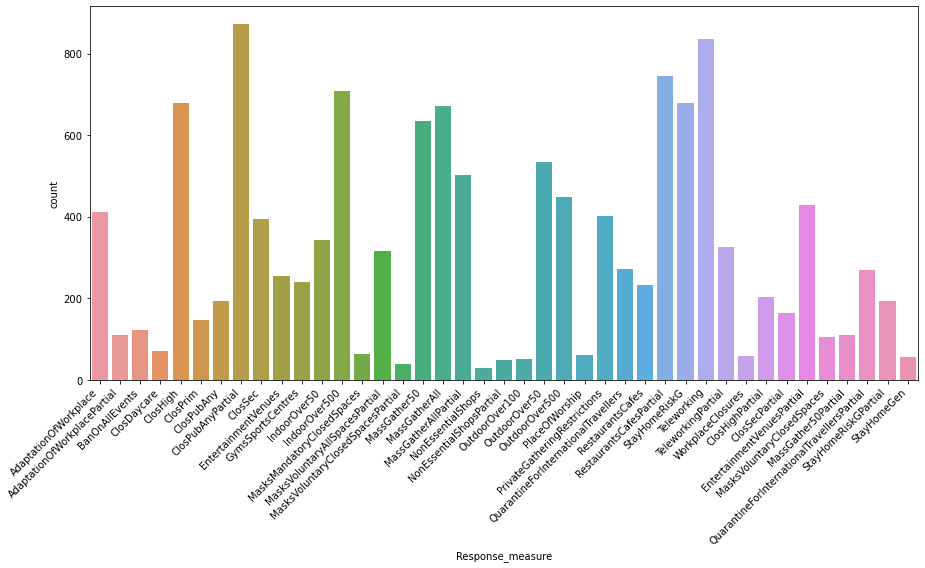

In [8]:
plt.subplots(figsize=(13,8))
p=sns.countplot(x="Response_measure",data=df) #plot count of each response measure
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.savefig("Plots/Restrictions.png")
plt.show()

Now a countplot of the number of restrictions is performed to see how they used restrictions differently. Here it is clear that Denmark and Finland had by far the most restrictions in effect. While Sweden especially used much less restrictions. This fits well with the general picture of the number of restrictions in 2020. That said, the number of restrictions is not a direct measure of how extreme the measures were and thereby how much they affect daily life. 

Link: https://en.wikipedia.org/wiki/Swedish_government_response_to_the_COVID-19_pandemic

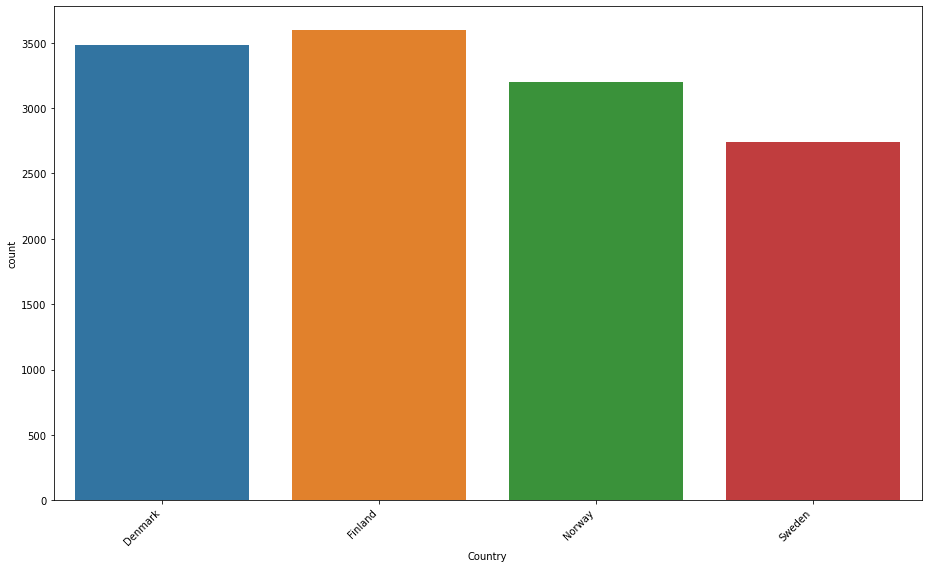

In [9]:
plt.subplots(figsize=(13,8))
p=sns.countplot(x="Country",data=df) # Plot count of each country
p.set_xticklabels(p.get_xticklabels(), rotation=45,ha="right")
plt.tight_layout()
plt.savefig("Plots/RestrictionsScandinavia.png")
plt.show()

# HISTOGRAMS FOR NO2 DATA

Loading BokehJS ...

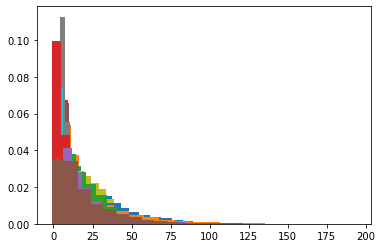

In [10]:
### Make histograms of data (Bokeh)
## Create empty plots for each country
# Denmark
p_dk = figure(title="Histogram of NO₂ - Denmark" ,plot_width=750, plot_height=500)
p_dk.title.text_font_size = "25px"
p_dk.xaxis.axis_label = r'$$\text{Concentration of }NO_2 \text{ in } µg/m^3$$'
p_dk.yaxis.axis_label = r'$$\text{Density of occurrences}$$'
dk_data = [dk2019, dk2020, dk2019_2, dk2020_2]
dk_label = ["2019 - København", "2020 - København", "2019 - Århus", "2020 - Århus"]

# Finland
p_fi = figure(title="Histogram of NO₂ - Finland",plot_width=750, plot_height=500)
p_fi.title.text_font_size = "25px"
p_fi.xaxis.axis_label = r'$$\text{Concentration of }NO_2 \text{ in } µg/m^3$$'
p_fi.yaxis.axis_label = r'$$\text{Density of occurrences}$$'
fi_data = [fi2019, fi2020, fi2019_2, fi2020_2]
fi_label = ["2019 - Helsinki", "2020 - Helsinki", "2019 - Oulu", "2020 - Oulu"]

# Norway
p_no = figure(title= "Histogram of NO₂ - Norway",plot_width=750, plot_height=500)
p_no.title.text_font_size = "25px"
p_no.xaxis.axis_label = r'$$\text{Concentration of }NO_2 \text{ in } µg/m^3$$'
p_no.yaxis.axis_label = r'$$\text{Density of occurrences}$$'
no_data = [no2019, no2020, no2019_2, no2020_2]
no_label = ["2019 - Oslo", "2020 - Oslo", "2019 - Trondheim", "2020 - Trondheim"]

# Sweden
p_se = figure(title="Histogram of NO₂ - Sweden",plot_width=750, plot_height=500)
p_se.title.text_font_size = "25px"
p_se.xaxis.axis_label = r'$$\text{Concentration of }NO_2 \text{ in } µg/m^3$$'
p_se.yaxis.axis_label = r'$$\text{Density of occurrences}$$'
se_data = [se2019, se2020, se2019_2, se2020_2]
se_label = ["2019 - Stockholm", "2020 - Stockholm", "2019 - Umeå", "2020 - Umeå"]

## Add histograms
hist_dk = {}
hist_fi = {}
hist_no = {}
hist_se = {}
colors = ['green','limegreen', "orange", "darkorange"]
year = ["2019", "2020", "2019_2", "2020_2"]
items_dk = []
items_fi= []
items_no = []
items_se = []

for indx,i in enumerate(year): # One histogram per year per location
    hist_tmp, edges, q = plt.hist(dk_data[indx]["Concentration"], bins = 20, density = True)
    hist_dk[i] = p_dk.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(fi_data[indx]["Concentration"], bins = 20, density = True)
    hist_fi[i] = p_fi.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(no_data[indx]["Concentration"],bins = 20, density = True)
    hist_no[i] = p_no.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    hist_tmp, edges, q = plt.hist(se_data[indx]["Concentration"], bins = 20, density = True)
    hist_se[i] = p_se.quad(top = hist_tmp, bottom=0, left=edges[:-1], right=edges[1:],
           fill_color=colors[indx], line_color="white", alpha=0.6, muted_alpha = 0.05)
    items_dk.append((dk_label[indx], [hist_dk[i]])) 
    items_fi.append((fi_label[indx], [hist_fi[i]])) 
    items_no.append((no_label[indx], [hist_no[i]])) 
    items_se.append((se_label[indx], [hist_se[i]]))


## Construct and add legends and Hover tools
legend_dk = Legend(items=items_dk, location=(0, -30)) # figure out where to add it
legend_fi = Legend(items=items_fi, location=(0, -30)) # figure out where to add it
legend_no = Legend(items=items_no, location=(0, -30)) # figure out where to add it
legend_se = Legend(items=items_se, location=(0, -30)) # figure out where to add it
p_dk.add_layout(legend_dk, 'left') # figure where to add it
p_dk.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_fi.add_layout(legend_fi, 'left') # figure where to add it
p_fi.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_no.add_layout(legend_no, 'left') # figure where to add it
p_no.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')
p_se.add_layout(legend_se, 'left') # figure where to add it
p_se.legend.click_policy="mute" #assigns the click policy (you can try to use ''hide')


## Combine plots using tabs
l1 = layout([[p_dk]])
l2 = layout([[p_fi]])
l3 = layout([[p_no]])
l4 = layout([[p_se]])

tab1 = Panel(child=l1,title="Denmark")
tab2 = Panel(child=l2,title="Finland")
tab3 = Panel(child=l3,title="Norway")
tab4 = Panel(child=l4,title="Sweden")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4 ])

curdoc().add_root(tabs)
output_notebook()
output_file('Plots/Histogram_NO2.html')
show(tabs)

## Histograms of original data
In the above, histograms the original data for each location in each of the years 2019 and 2020 is shown. These show the density of occurences for concentration of $NO_2$ for the different locations in the two different years. The plots are divided into different tabs, and by clicking on the legends to the left of the plots, we can mute or unmute histograms for certain years and places, and so we can choose ourselves what we want to look at.

By considering these plots, we see that the tallest bars in generel are to the left, meaning that the largest frequency of $NO_2$ concentrations are low for all measuring stations in both 2019 and 2020.
For Denmark, Norway and Sweden we see that the concentrations are higher outside the capital, as the bars to the left in the plots are lower than the ones for the capital. For Finland the opposite is true.

Comparing the histograms for the two years at any of the investigated measuring stations, shows that the bars to the left is taller for 2020, meaning that the frequency of occurences is higher for lower concentrations, which indicates that the concentration of $NO_2$ is generally lower for 2020 than for 2019.

These conclusions are supported by the violin plots below.

# VIOLIN PLOT FOR NO2 DATA

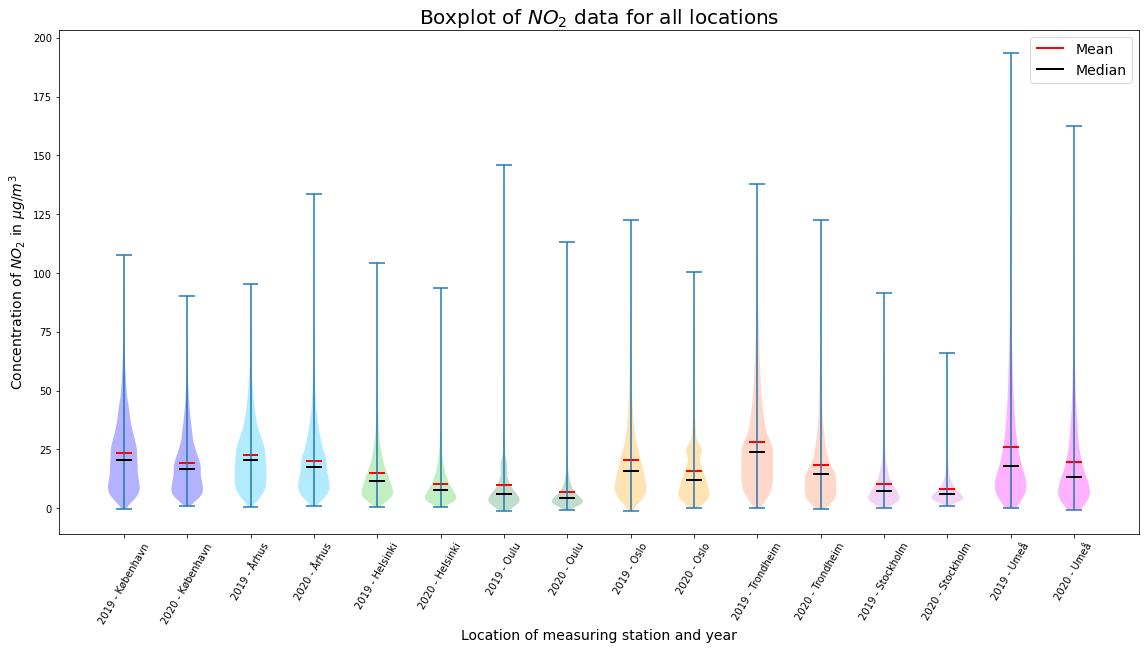

In [11]:
### Make violon plot of data
fig = plt.figure(figsize =(15,7))

# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])

# Creating plot
bp = ax.violinplot([data[i]["Concentration"] for i in range(0,16)], showmedians = True, showmeans= True)

colors = ["blue", "blue" , "deepskyblue", "deepskyblue", "limegreen", "limegreen", "seagreen" , "seagreen", "orange", "orange", "coral", "coral", "orchid", "orchid", "magenta", "magenta"]
 
for patch, color in zip(bp['bodies'], colors): # Change colors
    patch.set_facecolor(color)

# changing color and linewidth of
# medians and means
bp['cmedians'].set(color ='black',
               linewidth = 2)
bp['cmeans'].set(color ='red',
               linewidth = 2)
    
# x-axis labels
labels = dk_label[:] + fi_label[:] + no_label[:] + se_label[:]
ax.set_xticks(range(1,17))
ax.set_xticklabels(labels,rotation = 60)

# Adding title, axis labels and legend
font = {'weight': 'normal',
        'size': 20,
        }
plt.title(r"Boxplot of $NO_2$ data for all locations", fontdict=font)

font2 = {'weight': 'normal',
        'size': 14,
        }
ax.set_xlabel('Location of measuring station and year', fontdict=font2)
ax.set_ylabel(r'Concentration of $NO_2$ in $µg/m^3$', fontdict=font2);
ax.legend([bp['cmeans'], bp['cmedians']],['Mean', 'Median'], fontsize = 14)

plt.savefig('Plots/violin_plot.png')
plt.show()

## Violin plots of original data

To see how the data is distributed, we consider violin plots of the original data for each of the measuring stations.
We choose to do a violin plot, as we saw by the histograms that the data is not normally distributed, and so it makes more sense to consider the violin plot.

By this plot we find that the distribution of the data is very different for the different countries, as the shapes of the boxes  look very different. Likewise the distribution for each measuring station is different, as no shapes of boxes for each measuring station are the same.

Considering these plots, we see that both the median and mean become lower when considering each measuring station in respectively 2019 and 2020, confirming the observations we made when looking at the histograms, i.e. that the concentration of $NO_2$ in general is lower in 2020 than 2020.
From the violin plot we also observe that the maximum values for most data sets is quite far away from the box, and this is most likely due to how the data is collected. As the data consists of measurements made over an hour, this indicates that the concentration has either been high for a full hour, or that something has happened, such that some of the measurements within that hour is very high, resulting in a high value for the hour.

# TIME SERIES FOR NO2 DATA

In [12]:
### Time series data for all countries (Bokeh)
legend_names = ["2019 - København", "2020 - København", "2019 - Århus", "2020 - Århus", "2019 - Helsinki", "2020 - Helsinki", "2019 - Oulu", "2020 - Oulu", "2019 - Oslo" , "2020 - Oslo", "2019 - Trondheim", "2020 - Trondheim", "2019 - Stockholm", "2020 - Stockholm", "2019 - Umeå", "2020 - Umeå"]
colors = ["blue", "blue" , "deepskyblue", "deepskyblue", "limegreen", "limegreen", "seagreen" , "seagreen", "orange", "orange", "coral", "coral", "orchid", "orchid", "magenta", "magenta"]

## Daily means plot
p_day = figure(title="Time series of daily means of concentrations of NO₂",plot_width=750, plot_height=500,x_axis_type= 'datetime')
p_day.title.text_font_size = "20px"
p_day.xaxis.axis_label = 'Date'
p_day.yaxis.axis_label = r'$$NO_2 \text{ in } µg/m^3$$'

line_day = {}
items_day = []

# Calculate overall daily means for all measuring stations
day_means2019 = np.ones_like(daily_means[0]["Concentration"])
day_means2019[:] = daily_means[0]["Concentration"]
for i in range(2,16,2):
    day_means2019 += daily_means[i]["Concentration"]
day_means2019 /= 8

day_means2020 = np.ones_like(daily_means[1]["Concentration"])
day_means2020[:] = daily_means[1]["Concentration"]
for i in range(3,16,2):
    day_means2020 += daily_means[i]["Concentration"]
day_means2020 /= 8


## Weekly means plot
p_week = figure(title="Time series of weekly means of concentrations of NO₂",plot_width=750, plot_height=500)
p_week.title.text_font_size = "20px"
p_week.xaxis.axis_label = 'Week number'
p_week.yaxis.axis_label = r'$$NO_2 \text{ in } µg/m^3$$'

line_week = {}
items_week = []

# Calculate overall weekly means for all measuring stations
week_means2019 = np.ones_like(weekly_means[0]["Concentration"])
week_means2019[:] = weekly_means[0]["Concentration"]
for i in range(2,16,2):
    week_means2019 += weekly_means[i]["Concentration"]
week_means2019 /= 8

week_means2020 = np.ones_like(weekly_means[1]["Concentration"])
week_means2020[:] = weekly_means[1]["Concentration"]
for i in range(3,16,2):
    week_means2020 += weekly_means[i]["Concentration"]
week_means2020 /= 8

## Monthly means plot
p_mon = figure(title="Time series of monthly means of concentrations of NO₂",plot_width=750, plot_height=500)
p_mon.title.text_font_size = "20px"
p_mon.xaxis.axis_label = 'Month number'
p_mon.yaxis.axis_label = r'$$NO_2 \text{ in } µg/m^3$$'

line_mon = {}
items_mon = []

# Calculate overall monthly means for all measuring stations 
mon_means2019 = np.ones_like(monthly_means[0]["Concentration"])
mon_means2019[:] = monthly_means[0]["Concentration"]
for i in range(2,16,2):
    mon_means2019 += monthly_means[i]["Concentration"]
mon_means2019 /= 8

mon_means2020 = np.ones_like(monthly_means[1]["Concentration"])
mon_means2020[:] = monthly_means[1]["Concentration"]
for i in range(3,16,2):
    mon_means2020 += monthly_means[i]["Concentration"]
mon_means2020 /= 8

## Add lines to plot
for idx, dataset in enumerate(weekly_means): 
    line_day[legend_names[idx]] = p_day.line(daily_means[idx]["Date"], daily_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05, muted=True)
    items_day.append((legend_names[idx], [line_day[legend_names[idx]]])) 
    
    line_week[legend_names[idx]] = p_week.line(weekly_means[idx]["Week"], weekly_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05, muted=True)
    items_week.append((legend_names[idx], [line_week[legend_names[idx]]])) 

    line_mon[legend_names[idx]] = p_mon.line(monthly_means[idx]["Month"], monthly_means[idx]["Concentration"], color = colors[idx], alpha=0.6, muted_alpha = 0.05, muted=True)
    items_mon.append((legend_names[idx], [line_mon[legend_names[idx]]]))

line_day["Overall mean 2019"] = p_day.line(daily_means[0]["Date"],day_means2019, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_day.append(("Overall mean 2019", [line_day["Overall mean 2019"]]))
line_day["Overall mean 2020"] = p_day.line(daily_means[1]["Date"],day_means2020, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_day.append(("Overall mean 2020", [line_day["Overall mean 2020"]])) 

line_week["Overall mean 2019"] = p_week.line(weekly_means[0]["Week"],week_means2019, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_week.append(("Overall mean 2019", [line_week["Overall mean 2019"]]))
line_week["Overall mean 2020"] = p_week.line(weekly_means[1]["Week"],week_means2020, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_week.append(("Overall mean 2020", [line_week["Overall mean 2020"]])) 

line_mon["Overall mean 2019"] = p_mon.line(monthly_means[0]["Month"],mon_means2019, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_mon.append(("Overall mean 2019", [line_mon["Overall mean 2019"]]))
line_mon["Overall mean 2020"] = p_mon.line(monthly_means[1]["Month"],mon_means2020, color = 'black', alpha=0.6, muted_alpha = 0.05, muted=True)
items_mon.append(("Overall mean 2020", [line_mon["Overall mean 2020"]])) 

## Create legends and Hover tools
legend_day = Legend(items=items_day,location=(0, -30)) 
legend_week = Legend(items=items_week, location=(0, -30)) 
legend_mon = Legend(items=items_mon, location=(0, -30)) 
p_day.add_layout(legend_day, 'left')
p_day.legend.click_policy="mute"

p_week.add_layout(legend_week, 'left') 
p_week.legend.click_policy="mute"

p_mon.add_layout(legend_mon, 'left') 
p_mon.legend.click_policy="mute" 

## Combine plots using tabs
l1 = layout([[p_day]])
l2 = layout([[p_week]])
l3 = layout([[p_mon]])

tab1 = Panel(child=l1,title="Daily means")
tab2 = Panel(child=l2,title="Weekly means")
tab3 = Panel(child=l3,title="Monthly means")
tabs = Tabs(tabs=[ tab1, tab2, tab3])
  
curdoc().add_root(tabs)
output_notebook()
output_file('Plots/Timeseries_day_week_month.html')
show(tabs)

Loading BokehJS ...

## Time series of daily, weekly and monthly means
To be able to detect tendencies in the data, we find daily, weekly and monthly means for each measuring station for each year.
For each of these, the overall mean for all the measuring stations is also found to show the general tendencies over the two years.

By clicking on the names of the graphs we want to consider in the legend to the left of the graph, we can compare different levels of concentrations for the two years at each measuring station.
Doing so we see that for the daily means it is quite difficult to see the change in concentrations for the two different years for most of the measuring stations. Looking at the overall mean for the two years we notice that the peaks are not as high in 2020 as in 2019 even though the tendencies are similar, i.e. that the concentrations are high in January to March, lowest during the summer and early fall and then rising again when approaching December.
If we consider the weekly means, we notice that for most of the measuring stations the decrease in concentration from 2019 to 2020 is much more evident, such as for Trondheim and Helsinki. Looking at the overall mean we see that for most of the months there is a clear difference between 2019 and 2020, but over the summer the are at some points close to each other.
At last we look at the monthly means, and here we see the same tendencies as mentioned above for most of the measuring stations. However in this case, we find that the overall means for 2020 are always lower than the corresponding for 2019, and so it clear to see that the concentrations have decreased, when considering the months. 

To see it more clearly, a plot showing the changes in $NO_2$ level for the different stations is also plotted showing their geographic placements and changes in $NO_2$ over time. Here the circles indicate each station and the changes can be seen as changes in color, where green is below the guidelines from WHO, yellow is above the yearly guideline and red means the levels are above the daily guidelines. This clearly confirms the picture already seen, as the levels are lower in 2020 and actually it is below the WHO guidelines for both daily and yearly exposion. This shows that the way of living during the corona pandemic had an immense impact on the air pollution levels for $NO_2$ we meet in our daily life. 

With this knowledge we will look into why this might be, with a focus on the social restrictions that was imposed on our life in 2020.

# Differences in corona restrictions across Scandinavia

Though Scandinavia is deemed a fairly homogeneous population, both with the regards to the people living there and the way their communities are build, their response to covid-19 varied a fair amount. In the begninning of the pandemic Norway, Finland and Denmark used hard restrictions to avoid the virus spreading, while Sweden had a more relaxed approach. The same seemed to be the case for the second wave of the pandemic, but this actually changed towards the end of 2020, where Sweden enforced the most limiting restrictions. 

Looking at the below plot it can be seen that through 2020, Norway had the most days with restrictions, while the difference was very little, which is because all three countries enacted restrictions between the 10th and 12th of March. This makes the period of interest very similar, which is important, as it was seen in the data for NO2 that seasonal changes in concentrations already existed in 2019. 







Link: https://www.sciencedirect.com/science/article/pii/S0313592621000643

## PLOT NUMBER OF RESTRICTIONS PER COUNTRY IN TOTAL.

In [13]:
# Encode variables
data_rest = pd.get_dummies(df,prefix=['Response_measure'], columns = ['Response_measure']).sort_values(by="DATE_VALUE")

In [14]:
# Data preparation for plots
count=data_rest.groupby(["Country","DATE_VALUE"]).sum()
n_rest=count.sum(axis=1)
n_rest=n_rest.rename("Number of restrictions").reset_index()
test=n_rest.groupby("Country").count().reset_index()

In [15]:
# MAKE STATIONARY GEO PLOT
geo_str = json.dumps(json.load(open("data2/world-countries.json", 'r'))) # map data

In [16]:
## Plot total number of restriction
mapeu = folium.Map(location=[64, 11], # Munich coordinates
                  zoom_start=4)
folium.GeoJson(
    geo_str,
    name='geojson'
).add_to(mapeu)

folium.Choropleth(
            geo_data=geo_str, # map data
            data=test, # dataframe
            columns=['Country','Number of restrictions'], # used columns
            fill_color='Blues',
            key_on='feature.properties.name',#geojson country code
    legend_name='Total number of restriction days'
                        ).add_to(mapeu)
mapeu.save("Plots/NoRestrictions.html")
mapeu

## Barplot over hard restrictions

As mentioned, the restrictions varied quite a lot for the different countries, which can also be seen when accessing the most restrictive restrictions across the different countries. Focussing first on restrictions closing public spaces totally, it is clear to see the difference in strategies. While both Finland and Norway had public spaces, such as restaurants and entertainment venues, closed completely for around 80 days, Sweden never enacted this restriction. The next restriction is focussing on non essential shops, where they were closed in Denmark for nearly 30 days. It should be noted though that these would also be closed under the closure of public spaces restriction in Finland and Norway. This shows a more flexible adaption in Denmark, opening some parts of its public spaces before Finland and Norway. Again Sweden has never enacted a closing of non essential shops. 

The third restriction is with regards to daycare centers, which meant the smallest children all had to stay home. Here only Denmark and Norway enacted the restriction, again supporting the fact that these two countries had hard restrictions. The same can be seen for the enacted ban on all events, which ensure no events, neither outside nor inside. Here Denmark and Norway were the only two countries where this was enacted and for both it was in effect for more than 50 days. 

Finally, the closure of high schools is interesting. Here Sweden is the clear leader with a full closure of high schools for most of 2020 (the high schools are also counted as closed through the summer vacation, which can be slightly misinforming). High school students are in general easier to send home, as it is not considered necessary that an adult is also at home with them. This shows the difference in approach for the four countries quite clearly. 

In [17]:
# Create list of countries and colors to use
colors = ['red','green', "yellow", "blue"]
countries = ["Denmark", "Finland", "Norway", "Sweden"]
### Make histograms of data
## Create empty plot for closure of public spaces
p_CP = figure(title="Barplot of days with Closure of public spaces",plot_width=750, plot_height=500,x_range=countries)
p_CP.xaxis.axis_label = 'Country'
p_CP.yaxis.axis_label = 'Days with restriction'
ClosPubAny=data_rest[["Country","Response_measure_ClosPubAny"]].groupby("Country").sum().reset_index()

## Create empty plot for non esstential shops closed
p_NES = figure(title="Barplot of days with non essential shops closed",plot_width=750, plot_height=500,x_range=countries)
p_NES.xaxis.axis_label = 'Country'
p_NES.yaxis.axis_label = 'Days with restriction'
NonEssentialShops=data_rest[["Country","Response_measure_NonEssentialShops"]].groupby("Country").sum().reset_index()

## Create empty plot for closed daycares
p_CD = figure(title="Barplot of days with closed daycare",plot_width=750, plot_height=500,x_range=countries)
p_CD.xaxis.axis_label = 'Country'
p_CD.yaxis.axis_label = 'Days with restriction'
ClosDaycare=data_rest[["Country","Response_measure_ClosDaycare"]].groupby("Country").sum().reset_index()

## Create empty plot for ban of all events
p_BE = figure(title="Barplot of days with ban on all events",plot_width=750, plot_height=500,x_range=countries)
p_BE.xaxis.axis_label = 'Country'
p_BE.yaxis.axis_label = 'Days with restriction'
BanOnAllEvents=data_rest[["Country","Response_measure_BanOnAllEvents"]].groupby("Country").sum().reset_index()

## Create empty plot for closed high schools
p_CH = figure(title="Barplot of days with closed high schools",plot_width=750, plot_height=500,x_range=countries)
p_CH.xaxis.axis_label = 'Country'
p_CH.yaxis.axis_label = 'Days with restriction'
ClosHigh=data_rest[["Country","Response_measure_ClosHigh"]].groupby("Country").sum().reset_index()

## Create bar plots for each restriction
p_CP.vbar(x=ClosPubAny["Country"], top=ClosPubAny["Response_measure_ClosPubAny"], width=0.9,color=colors)
p_NES.vbar(x=NonEssentialShops["Country"], top=NonEssentialShops["Response_measure_NonEssentialShops"], width=0.9,color=colors)
p_CD.vbar(x=ClosDaycare["Country"], top=ClosDaycare["Response_measure_ClosDaycare"], width=0.9,color=colors)
p_BE.vbar(x=BanOnAllEvents["Country"], top=BanOnAllEvents["Response_measure_BanOnAllEvents"], width=0.9,color=colors)
p_CH.vbar(x=ClosHigh["Country"], top=ClosHigh["Response_measure_ClosHigh"], width=0.9,color=colors)

## Combine plots using tabs
l1 = layout([[p_CP]])
l2 = layout([[p_NES]])
l3 = layout([[p_CD]])
l4 = layout([[p_BE]])
l5 = layout([[p_CH]])

tab1 = Panel(child=l1,title="Closure of public spaces")
tab2 = Panel(child=l2,title="Non essential shops")
tab3 = Panel(child=l3,title="Closed daycare")
tab4 = Panel(child=l4,title="Ban on all events")
tab5 = Panel(child=l5,title="Closed High Schools")
tabs = Tabs(tabs=[ tab1, tab2, tab3, tab4,tab5 ])

curdoc().add_root(tabs)
output_notebook()
output_file('Plots/Restrictions_barcharts.html')
show(tabs)

Loading BokehJS ...

## PLOT NUMBER OF RESTRICTIONS AS TOTAL PER DAY FOR EACH COUNTRY

The number of restrictions in effect per day is also a good measure of the policies led by the different countries. It is clear that Denmark, Finland and Norway had close to the same number of restrictions in place through the period and reacted fast in the beginning, while also ending the year with the most restrictions. Sweden on the other hand did not enact as many restrictions at the same time through the whole period.

In [18]:
# MAKE GEOPLOT WITH TIME of restrictions
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = countries.rename(columns={'name': 'Country'})
joined_df=n_rest.merge(countries, on='Country')

In [19]:
# The next code parts are based on the following links:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#https://geohackweek.github.io/ghw2018_web_portal_inlandwater_co2/InteractiveTimeSeries.html 
#https://vverde.github.io/blob/interactivechoropleth.html
#Create color mapping
max_colour = max(joined_df['Number of restrictions'])
min_colour = min(joined_df['Number of restrictions'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
joined_df['colour'] = joined_df['Number of restrictions'].map(cmap)

In [20]:
#List of countries to map
country_list = joined_df['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df.DATE_VALUE-datetime.datetime(1970, 1, 1)
joined_df['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df[joined_df['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [21]:
## Set up proper data frames
countries_df = joined_df[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [22]:
## Create slider map
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Number of restrictions"
slider_map.save(outfile='Plots/TimeSliderResprDay.html')
slider_map

# DATA PREP NO2 DATA

In [23]:
# Collect NO2 data to use with geo mapping by first creating country column
data[0]["Country"]="Denmark"
data[1]["Country"]="Denmark"
data[2]["Country"]="Denmark"
data[3]["Country"]="Denmark"
data[4]["Country"]="Finland"
data[5]["Country"]="Finland"
data[6]["Country"]="Finland"
data[7]["Country"]="Finland"
data[8]["Country"]="Norway"
data[9]["Country"]="Norway"
data[10]["Country"]="Norway"
data[11]["Country"]="Norway"
data[12]["Country"]="Sweden"
data[13]["Country"]="Sweden"
data[14]["Country"]="Sweden"
data[15]["Country"]="Sweden"
# Then creating city columns
data[0]["City"]="Copenhagen"
data[1]["City"]="Copenhagen"
data[2]["City"]="Aarhus"
data[3]["City"]="Aarhus"
data[4]["City"]="Helsinki"
data[5]["City"]="Helsinki"
data[6]["City"]="Oulu"
data[7]["City"]="Oulu"
data[8]["City"]="Oslo"
data[9]["City"]="Oslo"
data[10]["City"]="Trondheim"
data[11]["City"]="Trondheim"
data[12]["City"]="Stockholm"
data[13]["City"]="Stockholm"
data[14]["City"]="Umeaa"
data[15]["City"]="Umeaa"
# Collect in proper data frames
# base_frames=[data[0],data[2],data[4],data[6],data[8],data[10],data[12],data[14]]
all_frames=[data[0],data[1],data[2],data[3],data[4],data[5],data[6],data[7],data[8],data[9],data[10],data[11],data[12],data[13],data[14],data[15]]
base_data=pd.concat(all_frames)
all_data=pd.concat(all_frames)

In [24]:
# Make daily dataset for main stations
no2_data=base_data[["Date","Concentration","Country"]].groupby(["Date","Country"]).mean().dropna().reset_index()
no2_data["Date"] =pd.to_datetime(no2_data["Date"])

# Make daily dataset for all stations
all_no2_data=all_data[["Date","Concentration","Country","City",'lon','lat']].groupby(["Date","Country","City"]).mean().dropna().reset_index()
all_no2_data['Date']=pd.to_datetime(all_no2_data['Date'])

## CREATE TIME SLIDER PLOT OVER AVERAGE DAILY NO2 VALUES FOR LARGEST CITY IN COUNTRIES.

Now the changes in $NO_2$-levels across the countries are compared over time. Here it becomes clear that especially in 2019 there are quite a lot of observations where the daily average across the stations in the countries are above both the 10 $\mu g/m^3$ and 25 $\mu g/m^3$ limits, which are the recommended yearly and daily limits from WHO. Especially the stations in Denmark and Norway seems to be problematic. Once the covid-19 restrictions kick in there is a clear difference. In general the air pollution becomes much smaller and instead of many days being at levels clearly above the limits, they are now around the limit or below for the average values. 

This indicates that the initial hypothesis, that Corona restrictions might influence the concentration of $NO_2$ considerably, might be correct. A deeper analysis into the correlation between $NO_2$ levels and Corona restrictions is therefore highly relevant. 

In [25]:
# The next code parts are based on the following link:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#Create color mapping
joined_df2=no2_data.merge(countries, on='Country')
max_colour = max(joined_df2['Concentration'])
min_colour = min(joined_df2['Concentration'])
cmap = cm.StepColormap(["green","yellow","red"],index=[1,6,25,25,35],vmin=min_colour,vmax=max_colour).scale(min_colour,max_colour).to_linear()

joined_df2['colour'] = joined_df2['Concentration'].map(cmap)
joined_df2["Date"] =pd.to_datetime(joined_df2["Date"])

In [26]:
# List of countries to map
country_list = joined_df2['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df2.Date-datetime.datetime(1970, 1, 1)
joined_df2['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df2[joined_df2['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [27]:
# Set up data frames for slider plot
countries_df = joined_df2[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [28]:
# Create slider plot
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Daily average NO2 concentration"
slider_map.save(outfile='Plots/TimeSlideravgdailyNO2.html')
slider_map

## CREATE CORRELATION PLOT TO SHOW INITAL EFFECT OF RESTRICTIONS.

Looking at the correlation, it is clear that the number of restrictions seems to have a reducing impact on the $NO_2$-levels. The impact seems be highest for Norway and Finland, which is not surprising, as they had many days with high $NO_2$ levels before restrictions was enacted, while they had nearly none after the restrictions was enacted. 

With this knowledge of a negative correlation, the next step is to start analysing the differences of the different restrictions, to see if any of those could be relevant for future reductions in $NO_2$ levels.

In [29]:
# Change date column to be in same dataformat and with same name.
n_rest=n_rest.rename(columns={"DATE_VALUE":"Date"})
no2_data["Date"]=pd.to_datetime(no2_data.Date)

In [30]:
# Create new data frame
new_df=no2_data.merge(n_rest,on=["Date","Country"],how="left").fillna(0)

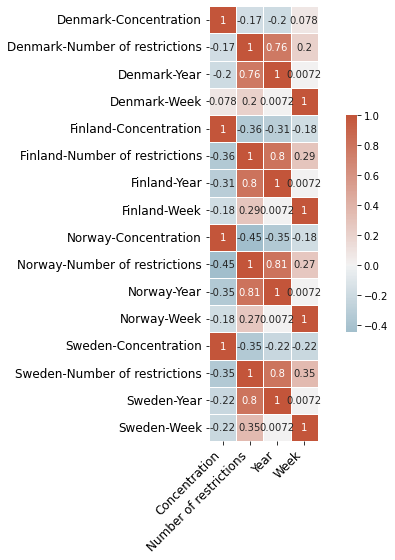

In [48]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

corr=new_df.groupby("Country").corr()

# Draw the heatmap with the mask and correct aspect ratio
g=sns.heatmap(corr, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.8, cbar_kws={"shrink": 0.5},annot=True,annot_kws={"size":10})
g.set_yticklabels(g.get_yticklabels(), size = 12)
g.set_xticklabels(g.get_xticklabels(), size = 12,ha='right')
g.tick_params(axis='x', labelrotation = 45)
ax.set(xlabel='', ylabel='')

plt.savefig("Plots/Correlations.png")
plt.show()

# CREATE WEEKLY PLOT OF NUMBER OF RESTRICTIONS


# THIS MIGHT NEED TO BE ERASED

In [32]:
# Change data to weekly average and look only at 2020
new_df["Year"]=new_df.Date.dt.isocalendar().year
new_df["Week"]=new_df.Date.dt.isocalendar().week

weekly=new_df[["Week","Concentration","Number of restrictions","Country","Year"]].groupby(["Country","Week","Year"]).mean().reset_index()

In [33]:
# Merge date back on and keep only the first date for each week. 
weekly=weekly.merge(new_df[["Week","Country","Date","Year"]], on=["Week","Country","Year"])
weekly=weekly.drop_duplicates(subset=['Week',"Country",'Year'])


In [34]:
# The next code parts are based on the following link:
#https://www.jumpingrivers.com/blog/interactive-maps-python-covid-19-spread/
#Create color mapping
joined_df3=weekly.merge(countries, on='Country')
max_colour = max(joined_df3['Number of restrictions'])
min_colour = min(joined_df3['Number of restrictions'])
cmap = cm.linear.YlOrRd_09.scale(min_colour, max_colour)
joined_df3['colour'] = joined_df3['Number of restrictions'].map(cmap)

In [35]:
#List of countries to map
country_list = joined_df3['Country'].unique().tolist()
country_idx = range(len(country_list))
# Create style_dict for time slider choropleth
style_dict = {}
# Change date to seconds and right data format for plot
a_timedelta=joined_df3.Date-datetime.datetime(1970, 1, 1)
joined_df3['DATE_SEC']=a_timedelta.dt.total_seconds().astype('U10')
for i in country_idx:
    country = country_list[i]
    result = joined_df3[joined_df3['Country'] == country]
    inner_dict = {}
    for _, r in result.iterrows():
        inner_dict[r['DATE_SEC']] = {'color': r['colour'], 'opacity': 5}
    style_dict[str(i)] = inner_dict

In [36]:
# Set up proper data frames
countries_df = joined_df3[['geometry']]
countries_gdf = gpd.GeoDataFrame(countries_df)
countries_gdf = countries_gdf.drop_duplicates().reset_index()

In [37]:
slider_map = folium.Map(location=[64, 11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')
_ = TimeSliderChoropleth(
    data=countries_gdf.to_json(),
    styledict=style_dict,

).add_to(slider_map)
_ = cmap.add_to(slider_map)
cmap.caption = "Number of restrictions"
slider_map.save(outfile='Plots/TimeSliderWeeklyRestrictions.html')
slider_map

#  CREATE HEATMAP WITH TIME TO SEE WHEN THE CRITICAL LEVEL IS REACHED IN THE DIFFERENT CITIES

In [38]:
# Change data to weekly average and look only at 2020
all_no2_data["Year"]=all_no2_data.Date.dt.isocalendar().year
all_no2_data["Week"]=all_no2_data.Date.dt.isocalendar().week


In [39]:
#Create color mapping
max_colour = max(all_no2_data['Concentration'])
min_colour = min(all_no2_data['Concentration'])
cmap = cm.StepColormap(["green","yellow","red"],index=[1,6,25,25,35],vmin=min_colour,vmax=max_colour).scale(min_colour,max_colour).to_linear()

all_no2_data['color'] = all_no2_data['Concentration'].map(cmap)
all_no2_data["Date"] =pd.to_datetime(all_no2_data["Date"])
all_no2_data['pop_up_info']=all_no2_data['City']

In [40]:
#Code reference
#https://codeutility.org/python-issue-with-pop-up-in-folium-timestampedgeojson-map-stack-overflow/
def create_geojson_features(df):
    print('> Creating GeoJSON features...')
    features = []
    for _, row in df.iterrows():
        feature = {
            'type': 'Feature',
            'geometry': {
                'type':'Point', 
                'coordinates':[row['lon'],row['lat']]
            },
            'properties': {
                'time': row['Date'].__str__(),
                'popup': str(row['pop_up_info']),
                'style': {'color' : row['color']},
                'icon': 'circle',
                'iconstyle':{
                    #'Color': row['color'],
                    'fillOpacity': 0.2,
                    'fillcolor':'crimson',
                    'stroke': 'true',
                    'weight':4,
                    'radius': 25
                }
            }
        }
        features.append(feature)
    return features
features = create_geojson_features(all_no2_data)

> Creating GeoJSON features...


In [41]:
## Make folium plot
from folium.plugins import TimestampedGeoJson
m = folium.Map([64,11], zoom_start=4,min_zoom=1, max_bounds=True,tiles='cartodbpositron')

TimestampedGeoJson(
        {'type': 'FeatureCollection',
        'features': features}
        , period='P1D'
        , duration='P1D'
        , add_last_point=False
        , auto_play=False
        , loop=False
        , max_speed=3
        , loop_button=True
        , date_options='YYYY/MM/DD'
        , time_slider_drag_update=True
    ).add_to(m)
m.save("Plots/HeatmapCriticalValues.html")
m

# DIFFERENCE BETWEEN 2019 AND 2020 FOR EACH CITY

In [42]:
all_no2_data[['City','Country','Year','Concentration']].groupby(['Country','City','Year']).mean()

Concentration
Country City       Year               
Denmark Aarhus     2019      22.879470
                   2020      20.097925
        Copenhagen 2019      23.553873
                   2020      19.289360
Finland Helsinki   2019      14.936600
                   2020      10.130232
        Oulu       2019      10.059203
                   2020       6.705406
Norway  Oslo       2019      20.497392
                   2020      16.083094
        Trondheim  2019      28.406888
                   2020      18.352423
Sweden  Stockholm  2019      10.396484
                   2020       7.968117
        Umeaa      2019      25.841543
                   2020      19.674272

## PLOT DIFFERENCES IN NO2 LEVEL MADE BY EACH RESTRICTION.

Finally the difference between the pre-covid levels and the $NO_2$-levels, when a policy was enacted, is compared for the four countries. From this it seems that some restrictions gave quite large reductions in $NO_2$-levels, but it should be noted that there is some interdependencies between them, plus some restrictions was mainly active in the winter period, where reductions was largest, while other was active during the summer months, where reductions were minimal.

Looking at the biggest reductions in $NO2$-levels it seems to be especially closure of public spaces, either completely or partially, plus restrictions on the number of persons that are allowed to gather. This makes perfect sense as these restrictions are assumed to be very limiting for our need of transportation. 

In [43]:
## Set up data frames 
REST_NO2=all_no2_data[['City','Country','Year','Concentration','Date']].merge(df,left_on=['Country','Date'],right_on=['Country','DATE_VALUE'],how="left").drop(columns=['DATE_VALUE'])
REST_NO2.fillna('Pre-Covid',inplace=True)
REST_NO2;

In [44]:
## Determine effect of restrictions
effect_rest=REST_NO2[['Response_measure','Concentration','Country']].groupby(['Response_measure','Country']).mean().reset_index()

In [45]:
## Find difference in effect of restrictions
diff_rest=effect_rest
diff_rest.loc[diff_rest['Country']=='Denmark','Concentration']=diff_rest[diff_rest['Country']=='Denmark'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Denmark')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Finland','Concentration']=diff_rest[diff_rest['Country']=='Finland'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Finland')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Norway','Concentration']=diff_rest[diff_rest['Country']=='Norway'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Norway')].Concentration.to_numpy()
diff_rest.loc[diff_rest['Country']=='Sweden','Concentration']=diff_rest[diff_rest['Country']=='Sweden'].Concentration-diff_rest[(diff_rest['Response_measure']=='Pre-Covid') & (diff_rest['Country']=='Sweden')].Concentration.to_numpy()

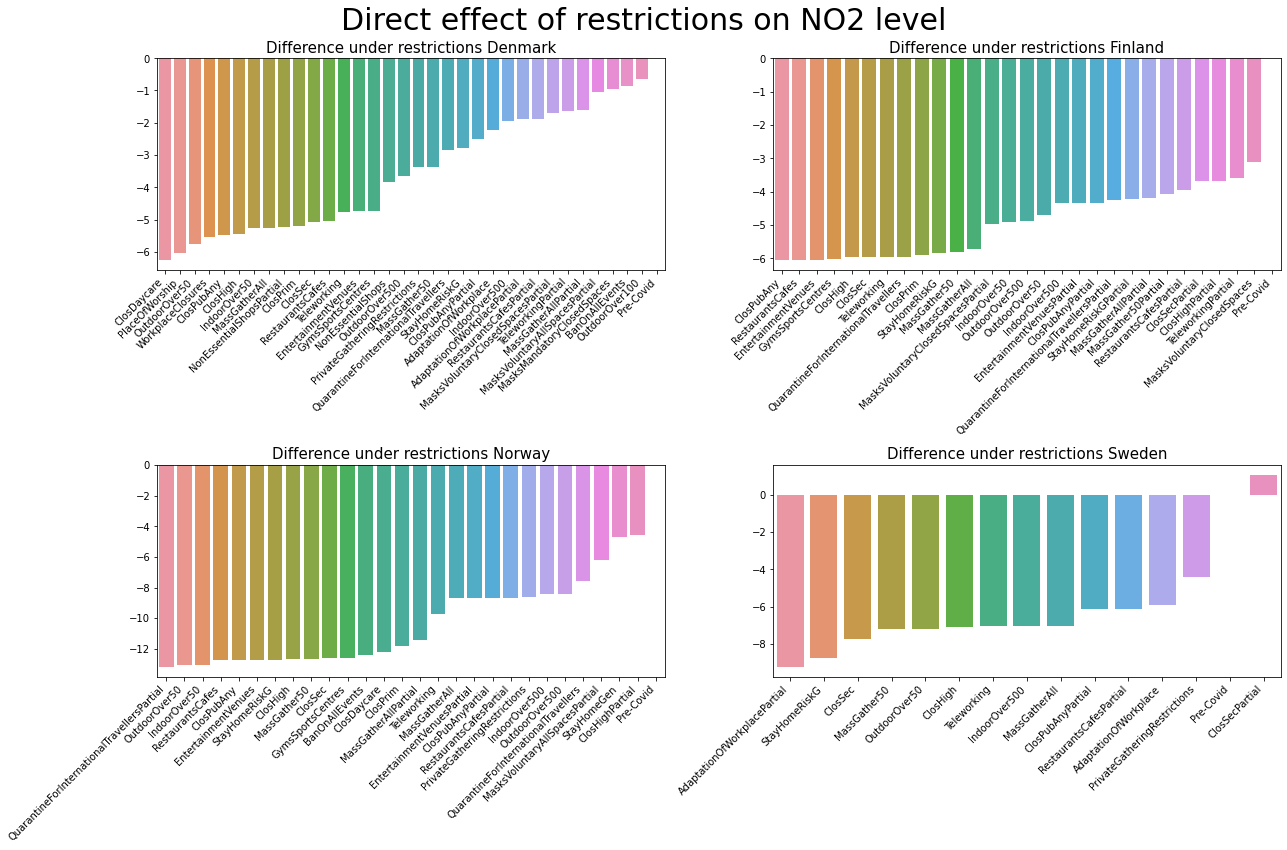

In [46]:
# Plot the effects for the different countries
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Direct effect of restrictions on NO2 level',fontsize=30)
sns.barplot(ax=axes[0,0],x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Denmark'],order=diff_rest[diff_rest['Country']=='Denmark'].sort_values('Concentration').Response_measure)
axes[0,0].set_xticklabels(axes[0,0].get_xticklabels(), rotation=45,ha="right",fontsize=10)
axes[0,0].set_title('Difference under restrictions Denmark',fontsize=15)
axes[0,0].set(xlabel=None)
axes[0,0].set(ylabel=None)
sns.barplot(ax=axes[0, 1],x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Finland'],order=diff_rest[diff_rest['Country']=='Finland'].sort_values('Concentration').Response_measure)
axes[0,1].set_xticklabels(axes[0,1].get_xticklabels(), rotation=45,ha="right",fontsize=10)
axes[0,1].set_title('Difference under restrictions Finland',fontsize=15)
axes[0,1].set(xlabel=None)
axes[0,1].set(ylabel=None)
sns.barplot(ax=axes[1,0],x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Norway'],order=diff_rest[diff_rest['Country']=='Norway'].sort_values('Concentration').Response_measure)
axes[1,0].set_xticklabels(axes[1,0].get_xticklabels(), rotation=45,ha="right",fontsize=10)
axes[1,0].set_title('Difference under restrictions Norway',fontsize=15)
axes[1,0].set(xlabel=None)
axes[1,0].set(ylabel=None)
sns.barplot(ax=axes[1, 1],x='Response_measure',y='Concentration',data=diff_rest[diff_rest['Country']=='Sweden'],order=diff_rest[diff_rest['Country']=='Sweden'].sort_values('Concentration').Response_measure)
axes[1,1].set_xticklabels(axes[1,1].get_xticklabels(), rotation=45,ha="right",fontsize=10)
axes[1,1].set_title('Difference under restrictions Sweden',fontsize=15)
axes[1,1].set(xlabel=None)
axes[1,1].set(ylabel=None)
plt.tight_layout()
plt.show()
fig.savefig('Plots/effect_restrictions.png')

# Genre: 
To tell the story, we have chosen the magazine style format, which allows for research of a serious topic, like the effects of restrictions on the air pollution in large cities. Using the magazine style allows us to describe the facts of the case using a build up by first describing the problem, then the different aspects (NO2 levels and restrictions), before compiling it together for seing the actual effects of the restrictions.

From the first block of visual narrative we in general used a consistent visual platform for the geo plots, and bokeh plots, mixing it up for the final plots to better compare them. From the second block feature distinction is used as we have feature for each city and need to be able to focus on them differently, when seing the differences. Finally the last visual narrative block we have attempted to create familiar objects and continuity.

For the narative structure we use a linear path, following what we want the reader to explore. This follows well with the magazine style. This gives limits the interactivity, but some comes by the click on/off and time sliders used, which allows the reader to play with the plots. 

Finally captions is used to create clear limits and changes, while comment repetitions (for some in the form of plots) is used to underline the most important parts. Finally the stage is set by an introductory text giving a clear limit for the article published. 


# Visualizations
In this project we have used different types of visualizations for the different parts.

At first we used histograms and violin plots to do the summary statistics, as they provided at nice, clear overview of how the data behaved, and so we could use these to make the initial conclusions about behaviour. Also, these types of plots are easy to read, even with the large amount of data we used, when making these plots.

After doing the initial summary statistics, we realized that looking at the data hour by hour would be too difficult to read anything from, and so we decided to do some simplification to certain degrees, which was then presented by the time series plot. We chose this type of plot as it was able to show us the behaviour of our data on a time scale, and so we were able to see tendencies, such as seasonal variation. This plot made us able to support the conclusions we made before, as we now were able to see that the tendencies shown before, i.e. that concentrations of $NO_2$ were lower in 2020 than in 2019, was actually true over the entire year, and not just much lower at a part of the year.

For the visualizations regarding restrictions, we primarily used choropleth plots, slider maps and heatmaps, which has the common denominator that they all include maps. This is a good idea in our case, as the data we want to present is country based, and so the maps give us the possibility of showing the differences in each country at once, and in the cases where we want to show data at the specific locations of the measuring stations, we are able to do so. The choropleth plot is used for the initial presentation of the data, which gives a nice overview, and afterwards we can use the slider maps and heatmaps to show the developments over time, which is relevant as we are dealing with time series data. For the slider maps we chose to use the $NO_2$-levels at the measuring stations as a measure of the level in the entire country, and this might be a bit misleading, but as the intention only was to show the tendencies in development and these were the same for both measuring stations in each country, we chose that it was reasonable to make this representation.

As a part of the summary statistics for the restrictions we also used bar charts, as this was a nice way to compare the different countries with regards to the restrictions as an overview.

In general we have used a lot of Bokeh plots, as we find that such a plot can contain much information, while it is still possible to mute some of it using the Hover tool, and thereby using Bokeh plots enables us to include much information in few plots, while it is still readable. Also, we like that we can make tabs to keep relevant plots in the same plot. Bokeh plots are also nice, because of the fact that they are interactive, and so the reader can also explore the data on their own terms.

# Discussion, extensions and conclussion

From the plots above and previous discussion it is clear that the expected correlation was found between social restrictions and decreases in NO2 levels. This is deemed a clear pro of the analysis. It still has some clear limitations, which could be explored in a larger research. 

If this article was to be extended, focus could be on first checking the effect of restrictions on other air pollution types. This would give a more sure foundation to draw conclusions from. Furthermore, a large pool of nations which was more diverse would also be an area of focus, and data reaching further back than 2019 and covering future years (when they become available) should also be investigated. This would allow to see if Corona brought any lasting changes with it. In the project we made assumptions about the pollution all over the country based on two measuring stations, and in order to make the picture of the national tendencies more correct, we could also have used data from more measuring stations in the already chosen countries.
Finally, areas that could effect NO2 levels should be explored more in depth. For the research done here focus has been on restrictions, assuming it is the largest reason for changes in behaviour and therefore decreases in air pollution levels. To get a better idea of which restrictions work and why these work best for decrease in air pollution levels, data on traffic and daily trips could be interesting as well. Other factors that could also influence the decrease, could be changes in vehicles types (which is happening, but much slower) or fear of contracting Corona (which is indirectly seen in the restrictions). These were deemed less important though, but should be highlighted more extensively in future research. 

Overall the conclusions are quite clear, with NO2 levels being down in 2020 compared to 2019 and the big change happening in the middle of March, when restrictions was put into place, and smallest during the summer period, where fewer restrictions was in place. The difference between number of restrictions between the countries was not very big, but the differences did not seem to have a large impact, meaning small lockdowns can have a big impact. Finally the effect of the different restrictions was explored. Here it was seen that the most effective restrictions was on social gatherings of any kind, and closure of public areas and shops. This was to be expected, but it was also interesting that partial adaptation of workplaces had quite a large effect, as this seem to have been adopted to some extend after Corona as well.

# Contributions
For the final project we have all collaborated on making the different parts of the project. Johannes (s164397) has primarily worked on setting up the website with figures and text, as well as making sure that history we want to tell is clear. Johannes was also the mail responsible, meaning that he took care of the contact to external sources.
Caroline (s184015) has primarily worked on making the data analysis for the $NO_2$-data, including the loading of the data and producing the plots directly related to this plots, as well as writing the text related to this. Caroline has also proofread the notebook, checked the plots, and written parts of the text not related to the plots.
Mathias (s174311) has done all the plotting of the plots related to the restrictions, and written the text related to this, as well as some of the other text.
We have all been a part of ensuring that the story was coherent, and that the plots were nice to look at.

